# Classification on the Walmart Dataset

Task: load the Walmart dataset, write a Support Vector Machine to perform classification over the Month or Season (S1:JAN-FEB-MAR, S2:APR,MAY,JUN, S3:JUL,AUG,SEP, S4:OCT,NOV,DEC) in which a purchase was made, test the network and plot the results for each class.
<!-- ![Walmart](https://raw.githubusercontent.com/Masterx-AI/Project_Retail_Analysis_with_Walmart/main/Wallmart1.jpg) -->


### Importing libraries

In [1]:
!pip install numpy matplotlib pandas seaborn scikit-learn


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns; sns.set_theme()
%matplotlib inline
%config InlineBackend.figure_format = "svg"

### Importing dataset

Link: https://www.kaggle.com/datasets/yasserh/walmart-dataset/input

In [3]:
import os
# Make sure to upload the data in colab
# Importing our dataset
df = pd.read_csv("Walmart.csv")
df.head(5)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


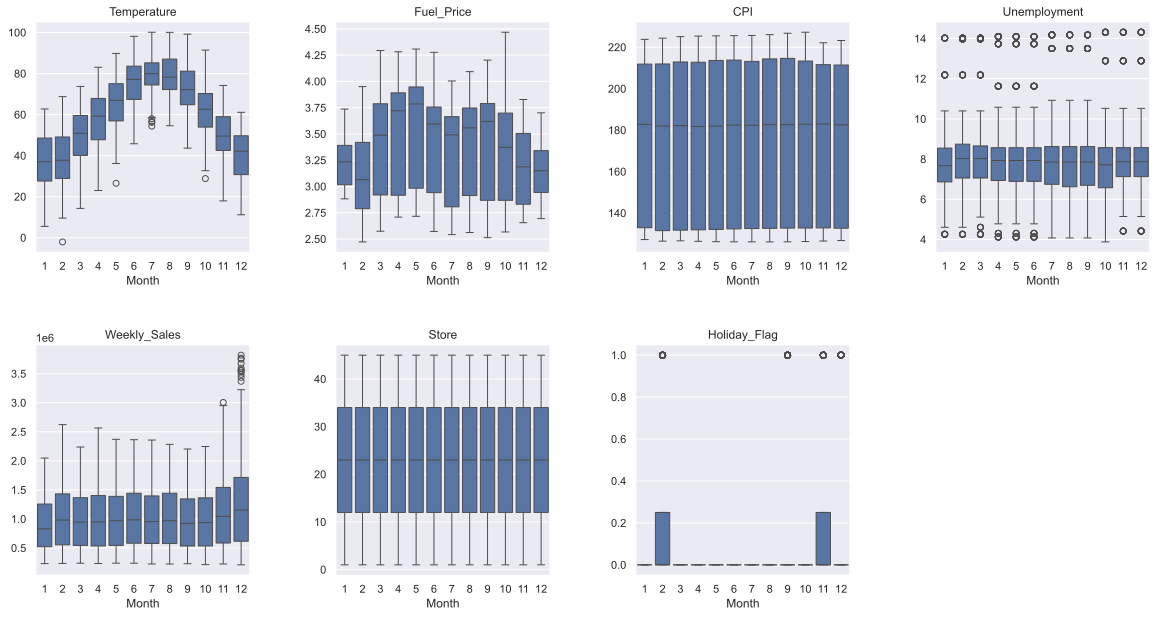

In [4]:
# Ensure the 'Month' and 'Year' columns are created before visualization
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)  # Convert the date column to datetime
df['Month'] = df['Date'].dt.month  # Extract the month of each date
df['Year'] = df['Date'].dt.year  # Extract the year of each date

# Visualize the distribution of each feature by month
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()
plt.subplots_adjust(hspace=0.4, wspace=0.4)
for i, column in enumerate(['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Weekly_Sales', 'Store', 'Holiday_Flag']):
  sns.boxplot(x='Month', y=column, data=df, ax=axs[i]) #, hue='Year'
  axs[i].set_title(f'{column}')
  axs[i].set_xlabel('Month')
  axs[i].set_ylabel('')

fig.delaxes(axs[-1])
plt.show()

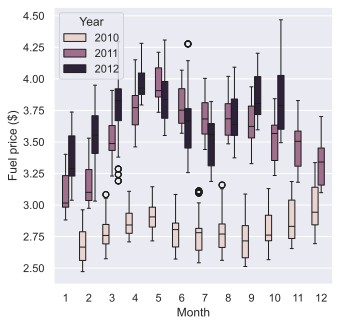

In [5]:
# Visualize the year distribution of the fuel price
plt.figure(figsize=(5, 5))
sns.boxplot(x='Month', y='Fuel_Price', data=df, hue='Year')
plt.xlabel('Month')
plt.ylabel('Fuel price ($)')
plt.show()

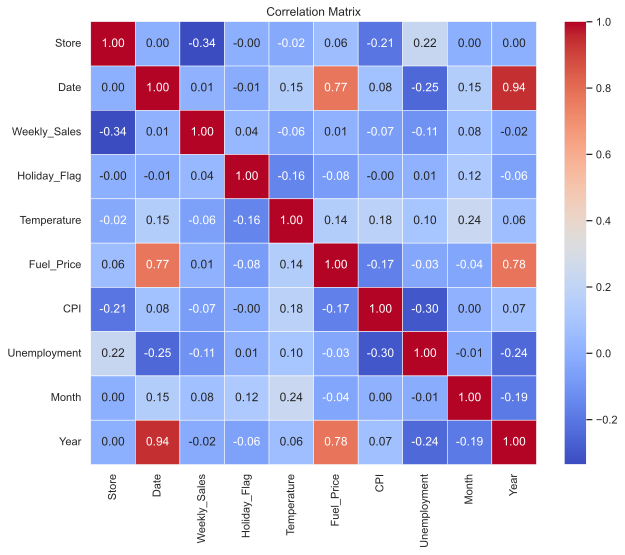

In [6]:
# Calculate the correlation matrix among the features
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

### Preparing data

One hot encodes the 'Store ID' column, extracts the month and season from the 'Date' column and drops the 'Date' column. Potentially adds the 'Year' column as an input feature.

Splits the data into training and testing sets.

In [7]:
# Set to true if you want to include the year as an input feature
include_year = False

In [8]:
from sklearn.model_selection import train_test_split
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True) # Convert the date column to datetime


df['Month'] = df['Date'].dt.month # Extract the month of each date
df['Year'] = df['Date'].dt.year # Extract the year of each date
df['Season'] = (df['Month']-1) // 3 + 1 # Compute the season of each date

df_final = df
# One-hot encode the store column
df_final = pd.get_dummies(df_final, columns=['Store'], drop_first=True)
if include_year:
  # One-hot encode the year column
  df_final = pd.get_dummies(df_final, columns=['Year'], drop_first=True)
  df_final = df_final.drop(columns=['Date', 'Season', 'Month'])
else:
  df_final = df_final.drop(columns=['Date', 'Season', 'Month', 'Year'])

# Split the data into training and testing sets
df_train, df_test, months_train, months_test, seasons_train, seasons_test = train_test_split(df_final, df['Month'], df['Season'], test_size=0.25, random_state=42)

## SVM definition
The model is defined as a pipeline composed of a normalization step and a Support Vector Machine classifier using the radial basis function kernel.

The best parameters for the SVM are found using a grid search with cross-validation.

In [ ]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
  StandardScaler(),
  SVC(kernel='rbf', class_weight='balanced')
)
# Define the hyperparameters to tune
param_grid = {'svc__C': [0.1, 1, 100, 1000, 100000],
              'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
grid = GridSearchCV(pipeline, param_grid, refit = True, verbose = 3)

### Training the model (seasons)

Finds the best parameters for the SVM using a grid search with cross-validation and trains the model using the 'Season' column as the target.

In [10]:
grid.fit(df_train, seasons_train)
model = grid.best_estimator_

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ..........svc__C=0.1, svc__gamma=1;, score=0.567 total time=   0.8s
[CV 2/5] END ..........svc__C=0.1, svc__gamma=1;, score=0.482 total time=   0.8s
[CV 3/5] END ..........svc__C=0.1, svc__gamma=1;, score=0.533 total time=   0.8s
[CV 4/5] END ..........svc__C=0.1, svc__gamma=1;, score=0.499 total time=   0.8s
[CV 5/5] END ..........svc__C=0.1, svc__gamma=1;, score=0.519 total time=   0.8s
[CV 1/5] END ........svc__C=0.1, svc__gamma=0.1;, score=0.399 total time=   0.8s
[CV 2/5] END ........svc__C=0.1, svc__gamma=0.1;, score=0.395 total time=   0.8s
[CV 3/5] END ........svc__C=0.1, svc__gamma=0.1;, score=0.427 total time=   0.8s
[CV 4/5] END ........svc__C=0.1, svc__gamma=0.1;, score=0.403 total time=   0.8s
[CV 5/5] END ........svc__C=0.1, svc__gamma=0.1;, score=0.420 total time=   0.8s
[CV 1/5] END .......svc__C=0.1, svc__gamma=0.01;, score=0.533 total time=   0.7s
[CV 2/5] END .......svc__C=0.1, svc__gamma=0.01

In [11]:
print(grid.best_params_)

{'svc__C': 100000, 'svc__gamma': 0.01}


### Model evaluation and results (seasons)

Plots the confusion matrix and the classification report for the model trained on the 'Season' column.

              precision    recall  f1-score   support

           1       0.69      0.79      0.74       354
           2       0.79      0.74      0.77       446
           3       0.84      0.89      0.86       454
           4       0.76      0.66      0.71       355

    accuracy                           0.78      1609
   macro avg       0.77      0.77      0.77      1609
weighted avg       0.78      0.78      0.77      1609



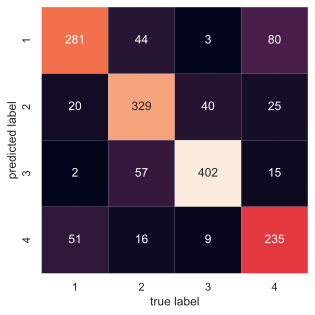

In [12]:
from sklearn.metrics import confusion_matrix
df_fit = model.predict(df_test)
mat = confusion_matrix(seasons_test, df_fit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(seasons_test),
            yticklabels=np.unique(seasons_test))
plt.xlabel('true label')
plt.ylabel('predicted label')

from sklearn.metrics import classification_report
print(classification_report(seasons_test, df_fit))

### Training the model (months)

In [13]:
grid.fit(df_train, months_train)
model = grid.best_estimator_

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ..........svc__C=0.1, svc__gamma=1;, score=0.122 total time=   1.0s
[CV 2/5] END ..........svc__C=0.1, svc__gamma=1;, score=0.060 total time=   0.9s
[CV 3/5] END ..........svc__C=0.1, svc__gamma=1;, score=0.055 total time=   0.9s
[CV 4/5] END ..........svc__C=0.1, svc__gamma=1;, score=0.088 total time=   0.9s
[CV 5/5] END ..........svc__C=0.1, svc__gamma=1;, score=0.136 total time=   0.9s
[CV 1/5] END ........svc__C=0.1, svc__gamma=0.1;, score=0.112 total time=   0.9s
[CV 2/5] END ........svc__C=0.1, svc__gamma=0.1;, score=0.059 total time=   0.9s
[CV 3/5] END ........svc__C=0.1, svc__gamma=0.1;, score=0.063 total time=   0.9s
[CV 4/5] END ........svc__C=0.1, svc__gamma=0.1;, score=0.087 total time=   0.9s
[CV 5/5] END ........svc__C=0.1, svc__gamma=0.1;, score=0.121 total time=   0.9s
[CV 1/5] END .......svc__C=0.1, svc__gamma=0.01;, score=0.171 total time=   0.9s
[CV 2/5] END .......svc__C=0.1, svc__gamma=0.01

In [14]:
print(grid.best_params_)

{'svc__C': 100000, 'svc__gamma': 0.01}


### Model evaluation and results (months)

Plots the confusion matrix and the classification report for the model trained on the 'Month' column.

              precision    recall  f1-score   support

           1       0.81      0.85      0.83        89
           2       0.49      0.61      0.54       130
           3       0.49      0.56      0.52       135
           4       0.54      0.53      0.53       154
           5       0.39      0.42      0.40       133
           6       0.53      0.52      0.53       159
           7       0.58      0.65      0.62       162
           8       0.50      0.48      0.49       147
           9       0.66      0.57      0.61       145
          10       0.67      0.59      0.63       148
          11       0.59      0.45      0.51        97
          12       0.73      0.63      0.67       110

    accuracy                           0.57      1609
   macro avg       0.58      0.57      0.57      1609
weighted avg       0.57      0.57      0.57      1609



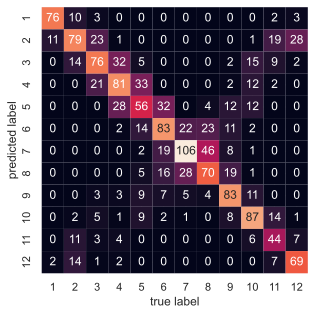

In [15]:
from sklearn.metrics import confusion_matrix
df_fit = model.predict(df_test)
mat = confusion_matrix(months_test, df_fit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(months_test),
            yticklabels=np.unique(months_test))
plt.xlabel('true label')
plt.ylabel('predicted label')

from sklearn.metrics import classification_report
print(classification_report(months_test, df_fit))